# Here I want to look at all the spills for XSEC70

## Load all spills
## Match them with gains
## sort them by gain
## Average them

In [1]:
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
import scipy.interpolate
from nxcals.api.extraction.data.builders import *

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

In [2]:
with open('rfko_gain_dataframe.pickle', 'rb') as f:
    df_gain = pickle.load(f)

In [3]:
start = df_gain.timestamp.min() # UTC
end = df_gain.timestamp.max() # UTC

## Load all the spills

In [4]:
df_xsec70 = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("T08.XSEC070-I/SpillData").build().toPandas()
df_xsec70.reset_index(drop=True, inplace = True)

23/01/17 09:07:11 WARN URLConfigurationSource: No URLs will be polled as dynamic configuration sources.


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_nxcals_pro/x86_64-centos7-gcc11-opt/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


23/01/17 09:07:20 WARN CheckAllocator: More than one DefaultAllocationManager on classpath. Choosing first found


In [5]:
df_xsec70["timestamp"] = df_xsec70["acqStamp"]/1000000000
df_xsec70["timestamp"] = [datetime.fromtimestamp(x) for x in df_xsec70["timestamp"]]

df_xsec70.sort_values(by = ["timestamp"], inplace = True)

df_merged = pd.merge_asof(df_xsec70, df_gain, on="timestamp", direction='nearest')

In [6]:
df_merged.sort_values(by = ["gain"], inplace = True)
df_merged.reset_index(drop=True, inplace = True)

In [7]:
df_merged.head(1)

__record_timestamp__  __record_version__             acqStamp   class  \
0   1669535512300000000                   0  1669535514141000000  BESTLD   

            cyclestamp         device   property        selector  \
0  1669535512300000000  T08.XSEC070-I  SpillData  CPS.USER.EAST2   

                                        semSpillData  nxcals_entity_id  \
0  {'elements': [-110, -11, -129, -11, 157, -208,...          22057411   

                timestamp  gain   voltage  energy  
0 2022-11-27 08:51:54.141   0.0 -1.797904     650

(array([1.440e+03, 8.000e+00, 2.800e+01, 6.100e+01, 2.490e+03, 8.711e+03,
        1.119e+03, 1.791e+03, 1.982e+03, 3.613e+03, 7.217e+03, 8.530e+02,
        5.200e+02, 3.410e+02, 4.590e+02, 9.702e+03, 4.210e+02, 2.920e+02,
        3.840e+02, 1.740e+02, 8.578e+03, 9.000e+00, 1.710e+02, 0.000e+00,
        1.000e+01, 7.300e+01, 2.400e+01, 1.200e+01, 1.000e+01, 6.000e+00,
        2.360e+02, 0.000e+00, 9.000e+00, 0.000e+00, 2.170e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 0.000e+00,
        8.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.800e+01]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
 <BarContainer object of 50 

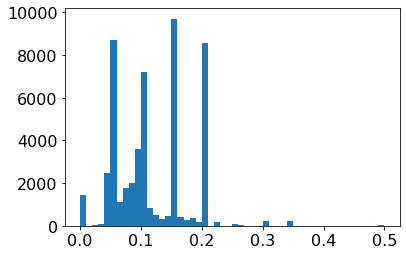

In [8]:
plt.hist(df_merged.gain, bins=50)

In [9]:
len(df_merged.gain)

50994

In [10]:
from collections import Counter
counts = Counter(df_merged.gain)
df_gain_sorted = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
df_gain_sorted = df_gain_sorted.reset_index().rename(columns={'index':'Number'})
df_gain_sorted.sort_values(by="Count", ascending=False, inplace=True)
df_gain_sorted.reset_index(drop=True, inplace=True)

df_gain_sorted[0:5]

Number  Count
0    0.15   9397
1    0.20   8478
2    0.05   7595
3    0.10   6743
4    0.09   1613

In [11]:
integrationDuration = 840
nbOfSamples = 42
t1 = np.arange(0, integrationDuration, int(integrationDuration / nbOfSamples))

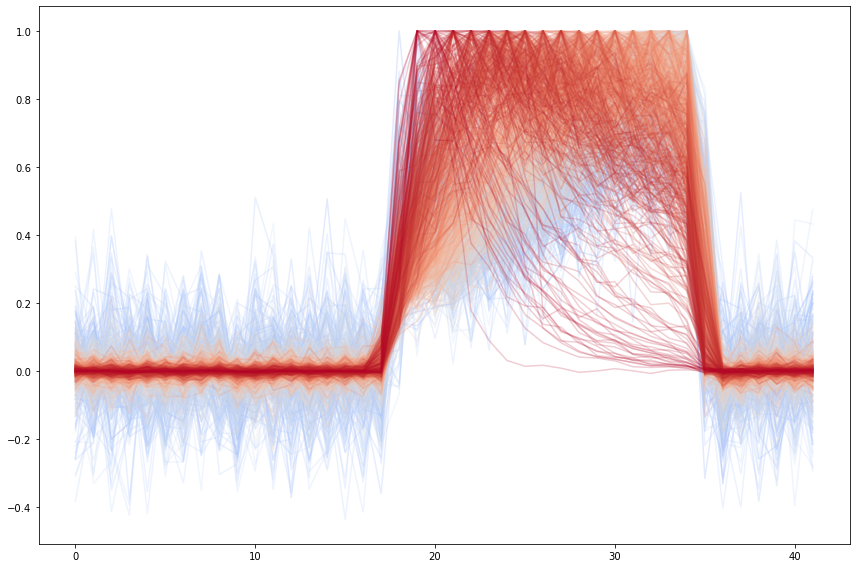

In [12]:
%matplotlib inline
from matplotlib import cm

no = 1757
n = len ( df_gain_sorted[0:no].sort_values(by="Number").Number )
color = iter(cm.coolwarm(np.linspace(0, 1, n)))


fig, ax = plt.subplots(tight_layout=True, figsize=(12,8))
# Plots in increasing gain order an average spill
for gain in list(df_gain_sorted[0:no].sort_values(by="Number").Number):
    df = df_merged.where(df_merged.gain == gain)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df["spill"] = [x["elements"] for x in df.semSpillData]
    df["intensity"] = [abs(x.sum()) for x in df.spill]
    df["length"] = [len(x) for x in df.spill]

    df = df.where(df.intensity > 10000)
    df = df.where(df.length == 42)
    df.dropna(inplace=True)
    df.reset_index(drop = True, inplace=True)

    c = next(color)
    try:
        mean = -df.spill.sum()/len(df.spill)
        ax.plot(mean/mean.max(), c=c, label=f"gain = {gain}", alpha = 0.2)
    except:
        pass
# ax.legend(fontsize=12)
plt.savefig("fig/spill_profile_"+str(no)+"_different_gain_300.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

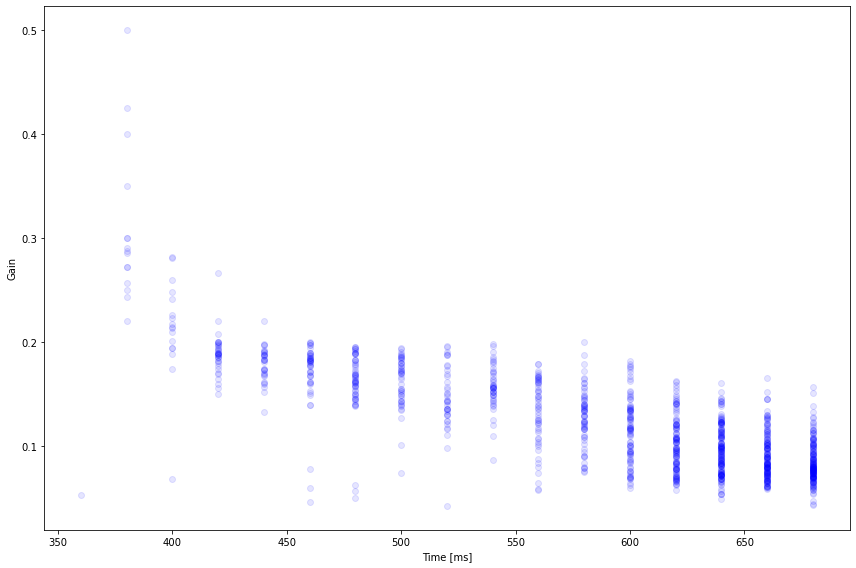

In [13]:
# Plot the maximum of the spike as a function of gain

%matplotlib inline
from matplotlib import cm

no = 1757
n = len ( df_gain_sorted[0:no].sort_values(by="Number").Number )
color = iter(cm.coolwarm(np.linspace(0, 1, n)))


fig, ax = plt.subplots(tight_layout=True, figsize=(12,8))
# Plots in increasing gain order an average spill
for gain in list(df_gain_sorted[0:no].sort_values(by="Number").Number):
    df = df_merged.where(df_merged.gain == gain)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df["spill"] = [x["elements"] for x in df.semSpillData]
    df["intensity"] = [abs(x.sum()) for x in df.spill]
    df["length"] = [len(x) for x in df.spill]

    df = df.where(df.intensity > 10000)
    df = df.where(df.length == 42)
    df.dropna(inplace=True)
    df.reset_index(drop = True, inplace=True)

    c = next(color)
    try:
        mean = -df.spill.sum()/len(df.spill)
        ax.scatter(t1[np.argmax(mean)], gain,  c="b", alpha=0.1, label=f"gain = {gain}")
    except:
        pass
# ax.legend(fontsize=12)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Gain")
plt.savefig("fig/spill_profile_"+str(no)+"_different_gain_peak_300.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

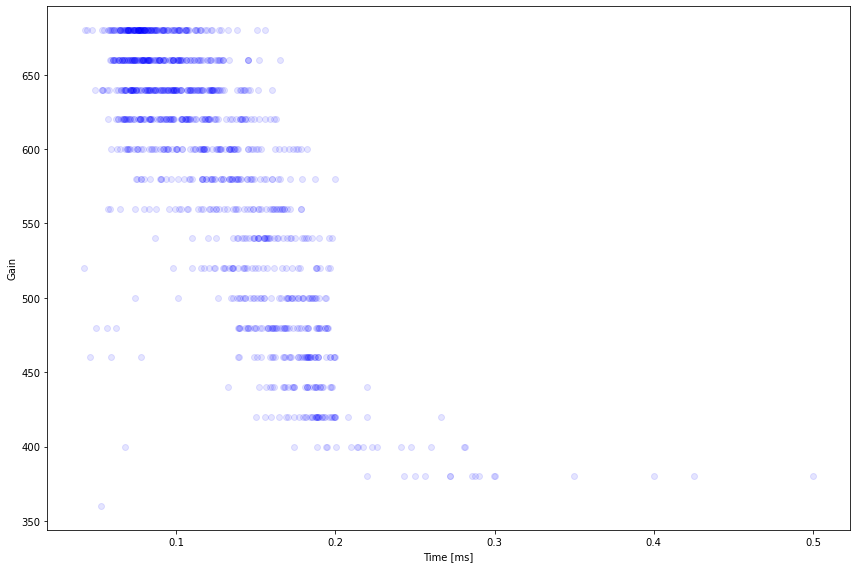

In [14]:
# Plot the maximum of the spike as a function of gain

%matplotlib inline
from matplotlib import cm

no = 1757
n = len ( df_gain_sorted[0:no].sort_values(by="Number").Number )
color = iter(cm.coolwarm(np.linspace(0, 1, n)))

fig, ax = plt.subplots(tight_layout=True, figsize=(12,8))
# Plots in increasing gain order an average spill
for gain in list(df_gain_sorted[0:no].sort_values(by="Number").Number):
    df = df_merged.where(df_merged.gain == gain)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df["spill"] = [x["elements"] for x in df.semSpillData]
    df["intensity"] = [abs(x.sum()) for x in df.spill]
    df["length"] = [len(x) for x in df.spill]

    df = df.where(df.intensity > 10000)
    df = df.where(df.length == 42)
    df.dropna(inplace=True)
    df.reset_index(drop = True, inplace=True)

    c = next(color)
    try:
        mean = -df.spill.sum()/len(df.spill)
        ax.scatter(gain, t1[np.argmax(mean)],  c="b", alpha=0.1, label=f"gain = {gain}")
    except:
        pass
# ax.legend(fontsize=12)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Gain")
plt.savefig("fig/spill_profile_"+str(no)+"_different_gain_peak_300.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

<IPython.core.display.Javascript object>


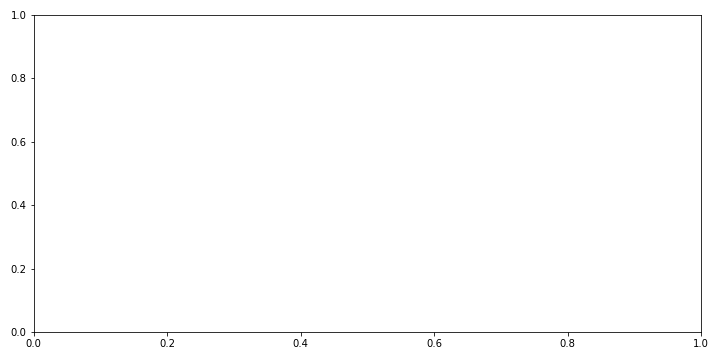

fail
fail
fail
fail
fail
fail


In [15]:
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook


no = 20
n = len ( df_gain_sorted[0:no].sort_values(by="Number").Number )
color = iter(cm.coolwarm(np.linspace(0, 1, n)))

fig, ax  = plt.subplots(figsize=(10,5), tight_layout=True)

def animate(i):
    ax.clear()

    try:        
        gain = df_gain_sorted[0:no].sort_values(by="Number").Number.reset_index(drop=True)[i]
        df = df_merged.where(df_merged.gain == gain)
        df.dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)

        df["spill"] = [x["elements"] for x in df.semSpillData]
        df["intensity"] = [abs(x.sum()) for x in df.spill]
        df["length"] = [len(x) for x in df.spill]

        df = df.where(df.intensity > 10000)
        df = df.where(df.length == 42)
        df.dropna(inplace=True)
        df.reset_index(drop = True, inplace=True)

        c = next(color)

        mean = -df.spill.sum()/len(df.spill)
        ax.plot(mean/mean.max())

    except:
        print("fail")
        pass
    return
    
ani = FuncAnimation(fig, animate, interval=1, blit=True, repeat=False, frames=no)
ani.save("gif/rfko_gain_spill_profile.gif", dpi=300, writer=PillowWriter(fps=1))